In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

def all_cells():    
    return HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# the functions below grabbed from http://www.astroml.org/book_figures/appendix/fig_neural_network.html
# our standard imports: matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')

radius = 0.3

arrow_kwargs = dict(head_width=0.05, fc='black')

def draw_connecting_arrow(ax, circ1, rad1, circ2, rad2):
    theta = np.arctan2(circ2[1] - circ1[1],
                       circ2[0] - circ1[0])

    starting_point = (circ1[0] + rad1 * np.cos(theta),
                      circ1[1] + rad1 * np.sin(theta))

    length = (circ2[0] - circ1[0] - (rad1 + 1.4 * rad2) * np.cos(theta),
              circ2[1] - circ1[1] - (rad1 + 1.4 * rad2) * np.sin(theta))

    ax.arrow(starting_point[0], starting_point[1],
             length[0], length[1], **arrow_kwargs)


def draw_circle(ax, center, radius):
    circ = plt.Circle(center, radius, fill=False, lw=2)
    ax.add_patch(circ)
    
# based on borrowed function we can create a new one to draw NN

def draw_net(input_size, output_size, hidden_layers=[], w=6, h=4):
  """Draw a network"""
  x = 0  # initial layer position
  
  ax = plt.subplot()
  ax.set_aspect('equal')
  ax.axis('off')

  ax.set_xlim([-2, -2 + w])
  ax.set_ylim([-h / 2 , h / 2 + 1])
  
  # set y position  
  y_input = np.arange(-(input_size - 1) / 2, (input_size + 1) / 2, 1)
  y_output = np.arange(-(output_size - 1) / 2, (output_size + 1) / 2, 1)
  y_hidden = [np.arange(-(n - 1) / 2, (n + 1) / 2, 1) for n in hidden_layers]
  
  # draw input layer
  plt.text(x, h / 2 + 0.5, "Capa\nEntrada", ha='center', va='top', fontsize=16)
  
  for i, y in enumerate(y_input):
    draw_circle(ax, (x, y), radius)
    ax.text(x - 0.9, y, '$x_%i$' % (input_size - 1 - i),
            ha='right', va='center', fontsize=16)
    draw_connecting_arrow(ax, (x - 0.9, y), 0.1, (x, y), radius)
  
  last_layer = y_input  # last layer y positions
  
  # draw hidden layers
  for ys in y_hidden:
    # shift x
    x += 2
    plt.text(x, h / 2 + 0.5, "Capa\nOculta", ha='center', va='top', fontsize=16)
    
    # draw neurons for each hidden layer
    for i, y1 in enumerate(ys):
      draw_circle(ax, (x, y1), radius)
      
      # connect a neuron with all neurons from previous layer
      if i != len(ys) - 1: # skip bias
        for y2 in last_layer:
          draw_connecting_arrow(ax, (x - 2, y2), radius, (x, y1), radius)
        
    # update last layer
    last_layer = ys
  
  x += 2  # update position for output layer
    
  # draw output layer
  plt.text(x, h / 2 + 0.5, "Capa\nSalida", ha='center', va='top', fontsize=16)

  for i, y1 in enumerate(y_output):
    draw_circle(ax, (x, y1), radius)
    ax.text(x + 0.8, y1, 'Salida', ha='left', va='center', fontsize=16)
    draw_connecting_arrow(ax, (x, y1), radius, (x + 0.8, y1), 0.1)

    # connect each output neuron with all neurons from previous layer
    for y2 in last_layer:
      draw_connecting_arrow(ax, (x - 2, y2), radius, (x, y1), radius)

all_cells()

<a id='inicio'></a>
# Proyecto 4: Aprendizaje de Máquina

## Integrantes: 

* Daniel Julián Rojas Cruz
* Johan Tanta Villanueva

Antes de proceder a mostrar la documentación de la implementación de KNN y K-means, definimos la distancia de Minkowski.
$$
\text{distancia} = (\sum_{k=1}^{n}{|p_k-q_k|}^{r})^{\frac{1}{r}}
$$
Valor de $r$ lleva a diferentes distancias:
- 1 ($L_1$): distancia Manhattan
- 2 ($L_2$): distancia Euclidiana
- $\infty$: distancia suprema

La implementación en python es la siguiente:
```
def distancia_minkowski(v1, v2, r):
    d = 0
    for i in range(len(v1)):
        d += pow(abs(v1[i] - v2[i]), r)
    return pow(d, 1/r)
```
Tanto $v1$ y $v2$ son las listas que contienen las coordenadas. Cuando $r=1$, se calcula la distancia Manhattan entre esas coordenadas. De igual forma para $r=2$, la distancia euclidiana es calculada.

In [2]:
hide_toggle(1)

In [3]:
import math

def distancia_minkowski(v1, v2, r):
    d = 0
    for i in range(len(v1)):
        d += pow(abs(v1[i] - v2[i]), r)
    return pow(d, 1/r)

Luego de implementar la distancia de Minkowski en python, la cual es usada posteriormente, se implementa el algoritmo K-means como aprendizaje no supervisado. 

In [4]:
hide_toggle(1)

In [5]:
import random
import copy

class KMeans():
    #En el constructor, se pasa la cantidad de agrupamientos que se quiere realizar
    def __init__(self, n_clusters, initialize = False):
        self.n_clusters = n_clusters
        self.n = 0
        self.centroides = []
        self.initialize = initialize
        #Dada una fila, en esta lista se guarda a cual centroide pertenece
        self.C = []
    #Se generan los centroides de manera aleatoria
    def generateCentroides(self, dimension):
        result = []
        for i in range(self.n_clusters):
            centroid = [random.uniform(-10, 20) for j in range(dimension)]
            result.append(centroid)

        return result

    # Se verifica si se necesita mas iteraciones
    def isEnough(self, c_column, df, distancia, r):
        #Se guarda a cuales centroides pertenecen las instancias antes de asignar
        #nuevamente a los clusters.
        c_antigua = copy.copy(c_column)
        self.asignar_clusters(df, distancia, r)

        ans = True
        #Verificamos si se mantienen iguales o no
        for i in range(len(c_antigua)):
            if (self.C[i] != c_antigua[i]):
                ans = False
                break

        return ans

    #Se entrena con un dataframe
    #Asimismo, se le pasa la funcion de la distancia de minkowski
    #r parametro de distancia de minkowski
    def fit(self, df, distancia, r=0):
        # De acuerdo a la cantidad de columnas se determina las dimensiones
        self.n = len(df.columns)

        # generacion de k centroides
        if(not self.initialize):
            self.centroides = self.generateCentroides(self.n)

        #Las instancias no pertenecen a ningun centroide, por lo que se asigna a -1
        self.C = [-1 for i in range(len(df))]
        
        #Se realiza una primera asignacion y actualizacion de centroides
        self.asignar_clusters(df, distancia, r)
        self.update_centroides(df)
        
        #Actualizamos los centroides las veces que sean necesarias.
        while(not self.isEnough(self.C, df, distancia, r)):
            self.update_centroides(df)

    #Funcion para actualizar los centroides.
    def update_centroides(self, df):
        # para cada centroide
        for i in range(self.n_clusters):
            #Como es el promedio de las coordenadas que pertencen al centroide
            #Guardamos en primer lugar, la suma que empieza en cero.
            suma = [0 for i in range(self.n)]
            n_records = 0

            #Para cada centroide
            for k in range(len(self.C)):
                #Identificar si es el centroide a analizar
                if (self.C[k] == i):
                    #contar cuantas veces se repite el centroide
                    n_records += 1
                    record = []
                    #Obtener las coordenadas de la instancia.
                    for j in range(self.n):
                        record.append(df.iloc[k, j])
                    #Sumar las coordenadas obtenidas con la suma que teniamos
                    suma = [suma[l] + record[l] for l in range(self.n)]
            
            #Si no hay instancia que pertenece al centroide, no se actualiza.
            if (n_records != 0):
                suma = [i/n_records for i in suma]
                self.centroides[i] = suma
    
    #Determinar a cual centroide pertenece cada instancia
    def asignar_clusters(self, df, distancia, r):
        for i in range(len(df)):
            record = []
            #Obtenemos las coordenadas.
            for j in range(self.n):
                record.append(df.iloc[i, j])

            #Hallar el de menor distancia con respecto a cada centroide
            minima = float('inf')
            idx = -1
            for k in range(self.n_clusters):
                centroide = self.centroides[k]
                dist = distancia(centroide, record, r)
                if (dist < minima):
                    minima = dist
                    idx = k
            #Guardar a cual centroide pertenece
            self.C[i] = idx

Por último, se implementa el algoritmo KNN como aprendizaje supervisado.

In [6]:
hide_toggle(1)

In [7]:
class KNN():
    #En el constructor se pasa el parámetro K que presenta la cantidad de vecinos mas cercanos
    #a analizar
    def __init__(self, k):
        self.k = k
        self.records = []
        self.values = []
    
    #Al ser un aprendizaje perezoso, solo extraemos las filas que nos interesan del dataframe
    def fit(self, df, atributos, clase):
        for index, row in df.iterrows():
            record = []
            for attr in atributos:
                record.append(row[attr])
            record.append(row[clase])

            self.records.append(record)

    #Al predecir, es donde se realiza el calculo principal
    def predict(self, atributos_value, distancia, r=0):
        #Calculamos las distancias que nos pasan a cada instancia del dataframe.
        #Luego los ordenamos
        self.records.sort(key=lambda record: distancia(record[:-1], atributos_value, r))

        count = {}
        #Calculamos la frecuencia de la variable clase de los K primeros 
        for i in range(self.k):
            record = self.records[i]
            clase_val = record[-1]
            if clase_val not in count:
                count[clase_val] = 1
            else:
                count[clase_val] += 1
        
        maximo = 0
        max_key = None
        #Determinamos cual es el valor de la variable target con mayor frecuencia.
        for key, val in count.items():
            if (val > maximo):
                maximo = val
                max_key = key

        return max_key

## Ejemplo N°1

Sea el siguiente dataset de prueba:

| Income_1 | Income_2 | d |
|----------|----------|---|
| 2        | 1        | 0 |
| 4        | 2        | 1 |
| 20       | 24       | 0 |
| 23       | 22       | 1 |
| 50       | 54       | 1 |
| 52       | 53       | 1 |

Se detalla el funcionamiento de K-means. En primer lugar, se llama al constructor de clase KMeans.
```
class KMeans():
    #En el constructor, se pasa la cantidad de agrupamientos que se quiere realizar
    def __init__(self, n_clusters, initialize = False):
        self.n_clusters = n_clusters
        self.n = 0
        self.centroides = []
        self.initialize = initialize
        #Dada una fila, en esta lista se guarda a cual centroide pertenece
        self.C = []

modelo = KMeans(2)
```
En el constructor se asigna la cantidad de clusters o agrupamientos con el cual se trabajará. Asimismo, el atributo $n$, $\text{centroides}$ y $C$ son asignados en la fase de entrenamiento. También, se brinda la opción de inicializarlo de manera manual, es decir, ya no realizarlo en la fase de entrenamiento

En la fase de entrenamiento se realiza el llamado de la funcion $\text{fit}$, en el cual se pasa el dataset a trabajar, la distancia Minkowski y el valor de $r$.
```
modelo.fit(df, distancia_minkowski , r=2)
```
En la función $\text{fit}$ se observa la asignación de la cantidad de dimensiones a trabajar, la cual está dado por la cantidad de columnas del dataset. 

```
def fit(self, df, distancia, r=0):
        # De acuerdo a la cantidad de columnas se determina las dimensiones
        self.n = len(df.columns)
```

También, se generan los centroides de manera aleatoria.
```
        # generacion de k centroides
        if(not self.initialize):
            self.centroides = self.generateCentroides(self.n)
        
    #Se generan los centroides de manera aleatoria
    def generateCentroides(self, dimension):
        result = []
        for i in range(self.n_clusters):
            centroid = [random.uniform(-10, 20) for j in range(dimension)]
            result.append(centroid)

        return result
```
Luego, se inicializa el atributo $C$ que representa el centroide de la instancia. Desde un inicio es -1 ya que se desconoce ello.
```
        #Las instancias no pertenecen a ningun centroide, por lo que se asigna a -1
        self.C = [-1 for i in range(len(df))]
```
Por lo que se realiza la primera asignacion y actualizacion de centroides.
```
        self.asignar_clusters(df, distancia, r)
        self.update_centroides(df)
```
En la función de $\text{asignar_clusters}$, identificamos a cual centroide pertenece cada instancia y lo guardamos en el atributo $C$.
```
    #Determinar a cual centroide pertenece cada instancia
    def asignar_clusters(self, df, distancia, r):
        for i in range(len(df)):
            record = []
            #Obtenemos las coordenadas.
            for j in range(self.n):
                record.append(df.iloc[i, j])

            #Hallar el de menor distancia con respecto a cada centroide
            minima = float('inf')
            idx = -1
            for k in range(self.n_clusters):
                centroide = self.centroides[k]
                dist = distancia(centroide, record, r)
                if (dist < minima):
                    minima = dist
                    idx = k
            #Guardar a cual centroide pertenece
            self.C[i] = idx
```
Luego de determinar a cual centroides pertenece cada instancia, actualizamos las coordenadas de los centroides. Se identifica todas las instancias que pertenecen a un centroide y se calcula el promedio de las coordenadas.
```
    #Funcion para actualizar los centroides.
    def update_centroides(self, df):
        # para cada centroide
        for i in range(self.n_clusters):
            #Como es el promedio de las coordenadas que pertencen al centroide
            #Guardamos en primer lugar, la suma que empieza en cero.
            suma = [0 for i in range(self.n)]
            n_records = 0

            #Para cada centroide
            for k in range(len(self.C)):
                #Identificar si es el centroide a analizar
                if (self.C[k] == i):
                    #contar cuantas veces se repite el centroide
                    n_records += 1
                    record = []
                    #Obtener las coordenadas de la instancia.
                    for j in range(self.n):
                        record.append(df.iloc[k, j])
                    #Sumar las coordenadas obtenidas con la suma que teniamos
                    suma = [suma[l] + record[l] for l in range(self.n)]
            
            #Si no hay instancia que pertenece al centroide, no se actualiza.
            if (n_records != 0):
                suma = [i/n_records for i in suma]
                self.centroides[i] = suma
```
Luego de realizar lo anterior, iteramos las veces que sean necesarias hasta que las instancias se mantengan en un centroide de manera constante.
```
        #Actualizamos los centroides las veces que sean necesarias.
        while(not self.isEnough(self.C, df, distancia, r)):
            self.update_centroides(df)
```
En la funcion $\text{isEnough}$ guarda la anterior asignacion de clusters y lo compara con una nueva asignación. Si se observa que cada instancia se mantienen con su centroide se retorna el valor $\text{true}$, lo cual significa que no es necesario seguir actualizando los centroides
```
    def isEnough(self, c_column, df, distancia, r):
        #Se guarda a cuales centroides pertenecen las instancias antes de asignar
        #nuevamente a los clusters.
        c_antigua = copy.copy(c_column)
        self.asignar_clusters(df, distancia, r)

        ans = True
        #Verificamos si se mantienen iguales o no
        for i in range(len(c_antigua)):
            if (self.C[i] != c_antigua[i]):
                ans = False
                break

        return ans
```
Luego de la fase de entrenamiento, podremos observar cuales han sido los centroides finales y la clasificacion de cada instancia
```
print("Centroides finales")
for centroide in modelo.centroides:
    printf(centroide)
    
print("Clasificacion de las instancias")
print(modelo.C)
```

In [8]:
hide_toggle(1)

K-Means
Centroides finales
Centroide  0 : [12.25, 12.25, 0.5]  ---> black
Centroide  1 : [51.0, 53.5, 1.0]  ---> black
Clasificacion de las instancias
Instancia 0 : 0 ---> red
Instancia 1 : 0 ---> red
Instancia 2 : 0 ---> red
Instancia 3 : 0 ---> red
Instancia 4 : 1 ---> azul
Instancia 5 : 1 ---> azul


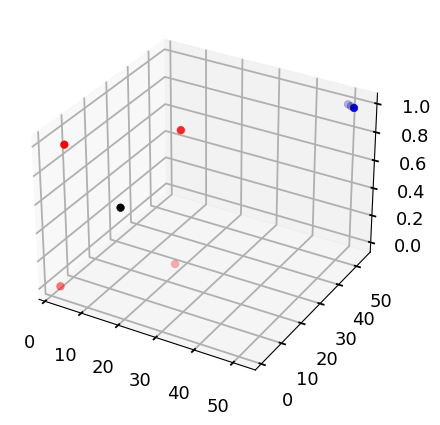

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

income1 = [2,4,20,23,50,52]
income2 = [1,2,24,22,54,53]
d = [0,1,0,1,1,1]
df = pd.DataFrame({"Income_1":income1,
                   "Income_2":income2,
                   "d" : d})
print("K-Means")
modelo = KMeans(2)
modelo.fit(df, distancia_minkowski , r=2)

red  = [[], [], []]
blue = [[], [], []]
black = [[], [], []]
print("Centroides finales")
for i in range(len(modelo.centroides)):
    print("Centroide ", str(i), ":", str(modelo.centroides[i]), " ---> black")
    black[0].append(modelo.centroides[i][0])
    black[1].append(modelo.centroides[i][1])
    black[2].append(modelo.centroides[i][2])
    
print("Clasificacion de las instancias")
for i in range(len(modelo.C)):
    print("Instancia", str(i), ":", modelo.C[i], end=" ---> ")
    r = df.iloc[i].tolist()
    if(modelo.C[i] == 0):
        print("red")
        red[0].append(r[0])
        red[1].append(r[1])
        red[2].append(r[2])
    else:
        print("azul")
        blue[0].append(r[0])
        blue[1].append(r[1])
        blue[2].append(r[2])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(red[0], red[1], red[2], color='red', s=30)
ax.scatter(blue[0], blue[1], blue[2], color='blue',s=30)
ax.scatter(black[0], black[1], black[2], color='black',s=30)
plt.show()

Se detalla el funcionamiento de KNN (aprendizaje supervisado). En primer lugar, se llama al constructor de clase KNN.
```
class KNN():
    def __init__(self, k):
        self.k = k
        self.records = []
        self.values = []

modelo2 = KNN(3)
```
En el constructor se pasa el parámetro K que presenta la cantidad de vecinos mas cercanos a analizar. Asimismo, los otros atributos se asignan en la fase de entrenamiento.

En la fase de entrenamiento se realiza el llamado de la funcion $\text{fit}$, en el cual se pasa el dataset a trabajar, los atributos a analizar y la variable target.
```
modelo2.fit(df,["Income_1", "Income_2"], "d")
```
En la función $\text{fit}$, por ser un aprendizaje perezoso, solo extraemos y guardamos los valores de las columnas que nos interesan.
```
def fit(self, df, atributos, clase):
        for index, row in df.iterrows():
            record = []
            for attr in atributos:
                record.append(row[attr])
            record.append(row[clase])

            self.records.append(record)
```
Luego, pasamos a predecir de manera inmediata, la cual pasamos las caracteristicas y la distancia de Minskowski. Esta funcion nos retorna el valor predecido.
```
modelo2.predict([10,10], distancia_minkowski, r=2)
```
En la funcion $\text{predict}$ se observa que se calcula todas las distancias de acuerdo a las instancias que tenemos.
```
    #Al predecir, es donde se realiza el calculo principal
    def predict(self, atributos_value, distancia, r=0):
        #Calculamos las distancias que nos pasan a cada instancia del dataset.
        #Luego los ordenamos
        self.records.sort(key=lambda record: distancia(record[:-1], atributos_value, r))
```
Luego, se analiza los $K$ primeros y calculamos las frecuencias de los valores de la variable clase.
```
        count = {}
        #Calculamos la frecuencia de la variable clase de los K primeros 
        for i in range(self.k):
            record = self.records[i]
            clase_val = record[-1]
            if clase_val not in count:
                count[clase_val] = 1
            else:
                count[clase_val] += 1
```
Finalmente, identificamos cual es el valor de la variable clase con mayor frecuencia.
```
        maximo = 0
        max_key = None
        #Determinamos cual es el valor de la variable target con mayor frecuencia.
        for key, val in count.items():
            if (val > maximo):
                maximo = val
                max_key = key

        return max_key
```

In [10]:
hide_toggle(1)

KNN algorithm


,Income_1,Income_2,d
0,2,1,0
1,4,2,1
2,20,24,0
3,23,22,1
4,50,54,1
5,52,53,1


Predicion 1 con input [-47, -2] : 0 ---> red
Predicion 2 con input [-22, -47] : 1 ---> blue
Predicion 3 con input [-21, -43] : 1 ---> blue
Predicion 4 con input [35, -5] : 1 ---> blue
Predicion 5 con input [-11, 25] : 0 ---> red
Predicion 6 con input [-21, -19] : 0 ---> red
Predicion 7 con input [18, -7] : 1 ---> blue
Predicion 8 con input [-18, 9] : 0 ---> red
Predicion 9 con input [-50, -39] : 0 ---> red
Predicion 10 con input [14, 21] : 1 ---> blue


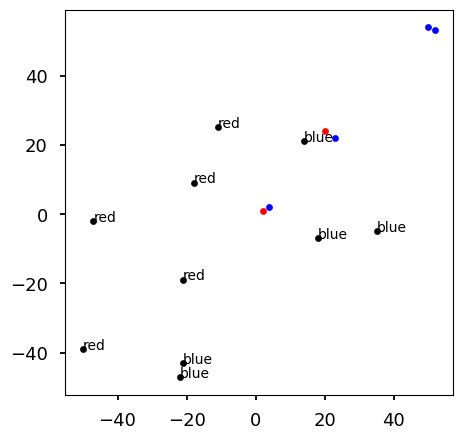

In [11]:
from IPython.display import display
import random

print("KNN algorithm")
modelo2 = KNN(3)
modelo2.fit(df,["Income_1", "Income_2"], "d")

display(df)

d0 = df[df["d"] == 0]
d1 = df[df["d"] == 1]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(d0["Income_1"].tolist(), d0["Income_2"].tolist(), color = "red", s=20)
ax.scatter(d1["Income_1"].tolist(), d1["Income_2"].tolist(), color = "blue", s=20)

for i in range(10):
    features = [random.randint(-50, 50), random.randint(-50, 50)]
    ax.scatter(features[0], features[1], color = "black", s=20)
    value = modelo2.predict(features, distancia_minkowski, r=2)
    print("Predicion", str(i+1), "con input", str(features), ":", value, end=" ---> ")
    if(value == 0):
        ax.annotate("red", xy =(features[0],features[1]), xytext=(features[0],features[1]))
        print("red")
    else:
        ax.annotate("blue", xy=(features[0],features[1]), xytext=(features[0],features[1]))
        print("blue")
plt.show()

## Observaciones:
- En el algoritmo K-means, a pesar que los centroides se generen de manera aleatoria, se observa que las coordenadas de los centroides finales se mantiene constante, al repetirlo varias veces.
- En el algoritmo KNN, al colocar como parámetro K = 3, se observa que hay puntos que tiene la clasificacion red (valor 0); sin embargo, al analizar más vecinos, es decir, K = 5, se percibe que todos los puntos son clasificados como blue (valor 1), esto se da ya que existen más puntos azules que rojos.

## Ejemplo 2
Ahora, vamos a trabajar con el dataset $adultIncome.csv$, la cual es parseado con anticipación para trabajar con valores numéricos. Asimismo, se observa que los valores de las columnas "age" y "hours per week" oscilan entre el intervalo $[0:100]$ por lo que no es necesario la normalización, ya que se podría garantizar que no habrá overflow

In [12]:
hide_toggle(1)

In [13]:
adult = pd.read_csv("adultIncome.csv")
adult.head(10)

,age,wc,education,marital status,race,gender,hours per week,IncomeClass
0,38,Private,HS-grad,Divorced,White,Male,40,<=50K
1,28,Private,Bachelors,Married,Black,Female,40,<=50K
2,37,Private,Masters,Married,White,Female,40,<=50K
3,31,Private,Masters,Never-married,White,Female,50,>50K
4,42,Private,Bachelors,Married,White,Male,40,>50K
5,37,Private,Some-college,Married,Black,Male,80,>50K
6,23,Private,Bachelors,Never-married,White,Female,30,<=50K
7,32,Private,HS-grad,Never-married,White,Male,40,<=50K
8,40,Private,Doctorate,Married,White,Male,60,>50K
9,59,Private,HS-grad,Divorced,White,Female,40,<=50K


In [14]:
hide_toggle(1)

In [15]:
df = pd.read_csv("dataframe.csv")
display(df.head(10))

,age,wc,education,marital status,race,gender,hours per week,IncomeClass
0,38,3,2,0,4,1,40,0
1,28,3,0,3,2,0,40,0
2,37,3,3,3,4,0,40,0
3,31,3,3,1,4,0,50,1
4,42,3,0,3,4,1,40,1
5,37,3,6,3,2,1,80,1
6,23,3,0,1,4,0,30,0
7,32,3,2,1,4,1,40,0
8,40,3,1,3,4,1,60,1
9,59,3,2,0,4,0,40,0


## Ejemplo 2: KMeans
Para este ejemplo, se utilizan 100 filas y las variables "age" y "IncomeClass". Asimismo, se inicializan los centroides de manera manual para obtener mejores resultados.

In [16]:
hide_toggle(1)

K-Means
Centroides Iniciales
Centroide  0 : [56.20112421085713, 0.6620201023689267]
Centroide  1 : [71.2444200342074, 0.6446285223694297]
Centroides finales
Centroide  0 : [28.242424242424242, 0.10606060606060606]  ---> black
Centroide  1 : [50.35294117647059, 0.47058823529411764]  ---> black
Clasificacion de las instancias
Red -> Cluster 0
Blue -> Cluster 1


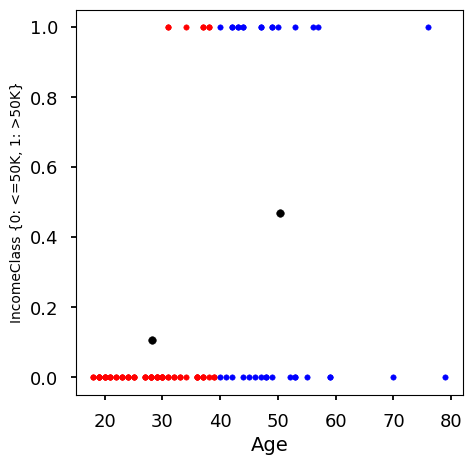

In [17]:
print("K-Means")
train = pd.DataFrame()
data = df.iloc[0:100]
train["age"] = data["age"]
train["IncomeClass"] = data["IncomeClass"]
modelo = KMeans(2, True)

modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 1)])
modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 1)])

print("Centroides Iniciales")
print("Centroide ", str(0), ":", str(modelo.centroides[0]))
print("Centroide ", str(1), ":", str(modelo.centroides[1]))

modelo.fit(train, distancia_minkowski , r=2)

red  = [[], []]
blue = [[], []]
black = [[], []]

print("Centroides finales")
for i in range(len(modelo.centroides)):
    print("Centroide ", str(i), ":", str(modelo.centroides[i]), " ---> black")
    black[0].append(modelo.centroides[i][0])
    black[1].append(modelo.centroides[i][1])

print("Clasificacion de las instancias")
print("Red -> Cluster 0")
print("Blue -> Cluster 1")
for i in range(len(modelo.C)):
    #print("Instancia", str(i), ":", modelo.C[i], end=" ---> \n")
    r = train.iloc[i].tolist()
    if(modelo.C[i] == 0):
        #print("red")
        red[0].append(r[0])
        red[1].append(r[1])
    else:
        #print("azul")
        blue[0].append(r[0])
        blue[1].append(r[1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(red[0], red[1], color='red', s=15)
ax.scatter(blue[0], blue[1], color='blue',s=15)
ax.scatter(black[0], black[1], color='black',s=30)
plt.xlabel("Age", fontsize=14)
plt.ylabel("IncomeClass {0: <=50K, 1: >50K}", fontsize=10)
plt.show(6,6)

## Ejemplo 2: KNN
Para este ejemplo, se utilizan 100 filas y las variables "age" y "education" y como variable clase "IncomeClass". Con K = 10.

In [18]:
hide_toggle(1)

KNN algorithm
Red  ->   <=50K
Blue ->   >50K
Education
0 :  Bachelors
1 :  Doctorate
2 :  HS-grad
3 :  Masters
4 :  Preschool
5 :  Prof-school
6 :  Some-college
Predicion 1 con [Age: 57, Education:  Doctorate]:  <=50K
Predicion 2 con [Age: 34, Education:  Prof-school]:  <=50K
Predicion 3 con [Age: 41, Education:  HS-grad]:  >50K
Predicion 4 con [Age: 8, Education:  Preschool]:  <=50K
Predicion 5 con [Age: 57, Education:  Some-college]:  <=50K
Predicion 6 con [Age: 20, Education:  Prof-school]:  <=50K
Predicion 7 con [Age: 58, Education:  Masters]:  <=50K
Predicion 8 con [Age: 14, Education:  HS-grad]:  <=50K
Predicion 9 con [Age: 83, Education:  Bachelors]:  <=50K
Predicion 10 con [Age: 31, Education:  Some-college]:  <=50K
Predicion 11 con [Age: 10, Education:  Preschool]:  <=50K
Predicion 12 con [Age: 38, Education:  Masters]:  <=50K
Predicion 13 con [Age: 48, Education:  Prof-school]:  <=50K
Predicion 14 con [Age: 87, Education:  Masters]:  <=50K
Predicion 15 con [Age: 80, Education

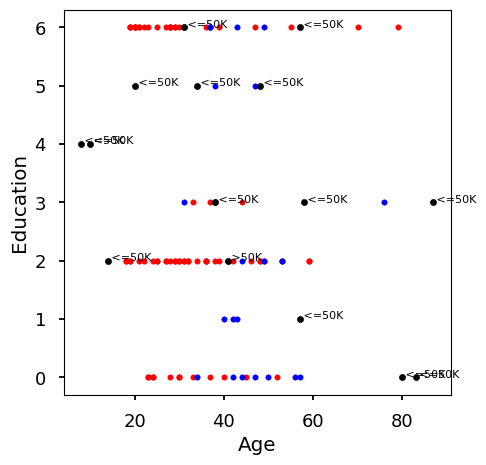

In [19]:
print("KNN algorithm")

values_ed= {2: ' HS-grad', 0: ' Bachelors', 3: ' Masters', 6: ' Some-college', 1: ' Doctorate', 5: ' Prof-school', 4: ' Preschool'}
values_ic = {0: ' <=50K', 1: ' >50K'}
    
train = pd.DataFrame()
data = df.iloc[0:100]
train["age"] = data["age"]
train["education"] = data["education"]
train["IncomeClass"] = data["IncomeClass"]
modelo2 = KNN(15)
modelo2.fit(train,["age", "education"], "IncomeClass")

d0 = train[train["IncomeClass"] == 0]
d1 = train[train["IncomeClass"] == 1]

print("Red  -> ", values_ic[0])
print("Blue -> ", values_ic[1])

print("Education")
for i in range(len(values_ed)):
    print(i, ":", values_ed[i])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(d0["age"].tolist(), d0["education"].tolist(), color = "red", s=15)
ax.scatter(d1["age"].tolist(), d1["education"].tolist(), color = "blue", s=15)

for i in range(15):
    features = [random.randint(0, 100), random.randint(0, 6)]
    ax.scatter(features[0], features[1], color = "black", s=20)
    value = modelo2.predict(features, distancia_minkowski, r=2)
    print("Predicion {} con [Age: {}, Education: {}]: {}".format(i+1, features[0], values_ed[features[1]], values_ic[value]))
    ax.annotate(values_ic[value], xy =(features[0],features[1]), xytext=(features[0],features[1]), fontsize=8)

plt.xlabel("Age")
plt.ylabel("Education")
plt.show(10,10)

# Ejemplo 3
## Ejemplo 3: KMeans
Para este ejemplo, se utilizan 1000 filas y las variables "age" y "IncomeClass". Asimismo, se inicializan los centroides de manera manual para obtener mejores resultados.

In [20]:
hide_toggle(1)

K-Means
Centroides Iniciales
Centroide  0 : [28.421946672325927, 0.29261241547683814]
Centroide  1 : [70.14727196683965, 0.6775246092278585]
Centroides finales
Centroide  0 : [28.993231810490695, 0.155668358714044]  ---> black
Centroide  1 : [50.04645476772616, 0.3960880195599022]  ---> black
Clasificacion de las instancias
Red -> Cluster 0
Blue -> Cluster 1


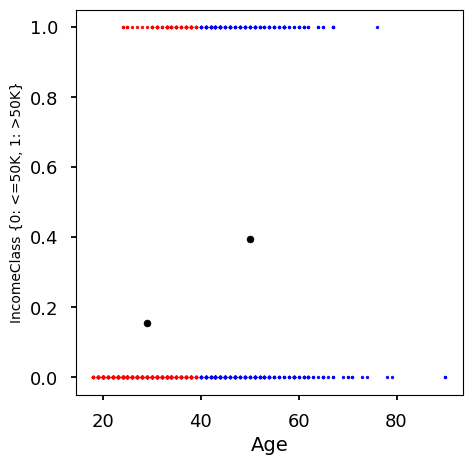

In [21]:
print("K-Means")
train = pd.DataFrame()
data = df.iloc[0:1000]
train["age"] = data["age"]
train["IncomeClass"] = data["IncomeClass"]
modelo = KMeans(2, True)

modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 1)])
modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 1)])

print("Centroides Iniciales")
print("Centroide ", str(0), ":", str(modelo.centroides[0]))
print("Centroide ", str(1), ":", str(modelo.centroides[1]))

modelo.fit(train, distancia_minkowski , r=2)

red  = [[], []]
blue = [[], []]
black = [[], []]

print("Centroides finales")
for i in range(len(modelo.centroides)):
    print("Centroide ", str(i), ":", str(modelo.centroides[i]), " ---> black")
    black[0].append(modelo.centroides[i][0])
    black[1].append(modelo.centroides[i][1])

print("Clasificacion de las instancias")
print("Red -> Cluster 0")
print("Blue -> Cluster 1")
for i in range(len(modelo.C)):
    #print("Instancia", str(i), ":", modelo.C[i], end=" ---> \n")
    r = train.iloc[i].tolist()
    if(modelo.C[i] == 0):
        #print("red")
        red[0].append(r[0])
        red[1].append(r[1])
    else:
        #print("azul")
        blue[0].append(r[0])
        blue[1].append(r[1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(red[0], red[1], color='red', s=4)
ax.scatter(blue[0], blue[1], color='blue',s=4)
ax.scatter(black[0], black[1], color='black',s=25)
plt.xlabel("Age", fontsize=14)
plt.ylabel("IncomeClass {0: <=50K, 1: >50K}", fontsize=10)
plt.show(6,6)

## Ejemplo 3: KNN
Para este ejemplo, se utilizan 1000 filas y las variables "age" y "education" y como variable clase "IncomeClass". Con K = 15.

In [22]:
hide_toggle(1)

KNN algorithm
Red  ->   <=50K
Blue ->   >50K
Education
0 :  Bachelors
1 :  Doctorate
2 :  HS-grad
3 :  Masters
4 :  Preschool
5 :  Prof-school
6 :  Some-college
Predicion 1 con [Age: 97, Education:  Some-college]:  <=50K
Predicion 2 con [Age: 73, Education:  HS-grad]:  <=50K
Predicion 3 con [Age: 0, Education:  Some-college]:  <=50K
Predicion 4 con [Age: 43, Education:  Masters]:  <=50K
Predicion 5 con [Age: 30, Education:  Doctorate]:  <=50K
Predicion 6 con [Age: 85, Education:  Preschool]:  <=50K
Predicion 7 con [Age: 47, Education:  Masters]:  <=50K
Predicion 8 con [Age: 37, Education:  Bachelors]:  >50K
Predicion 9 con [Age: 92, Education:  Prof-school]:  <=50K
Predicion 10 con [Age: 68, Education:  Doctorate]:  <=50K
Predicion 11 con [Age: 55, Education:  Doctorate]:  <=50K
Predicion 12 con [Age: 57, Education:  Some-college]:  <=50K
Predicion 13 con [Age: 2, Education:  Some-college]:  <=50K
Predicion 14 con [Age: 15, Education:  Doctorate]:  <=50K
Predicion 15 con [Age: 61, Educ

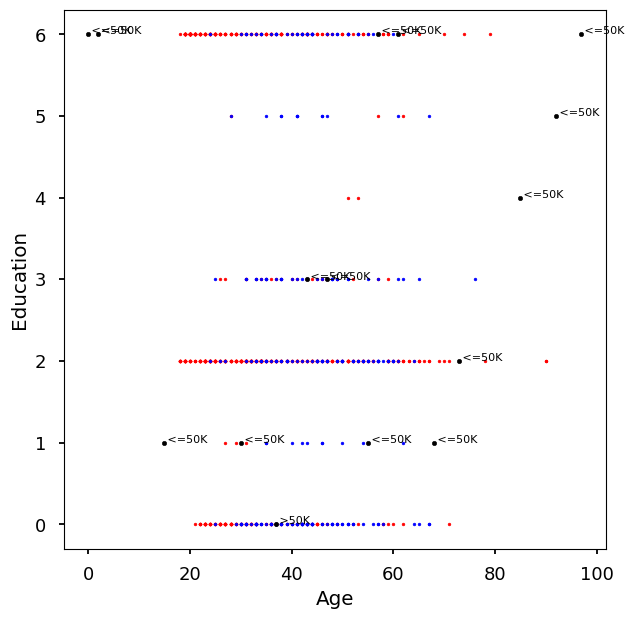

In [23]:
print("KNN algorithm")

values_ed= {2: ' HS-grad', 0: ' Bachelors', 3: ' Masters', 6: ' Some-college', 1: ' Doctorate', 5: ' Prof-school', 4: ' Preschool'}
values_ic = {0: ' <=50K', 1: ' >50K'}
    
train = pd.DataFrame()
data = df.iloc[0:1000]
train["age"] = data["age"]
train["education"] = data["education"]
train["IncomeClass"] = data["IncomeClass"]
modelo2 = KNN(15)
modelo2.fit(train,["age", "education"], "IncomeClass")

d0 = train[train["IncomeClass"] == 0]
d1 = train[train["IncomeClass"] == 1]

print("Red  -> ", values_ic[0])
print("Blue -> ", values_ic[1])
print("Education")
for i in range(len(values_ed)):
    print(i, ":", values_ed[i])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.scatter(d0["age"].tolist(), d0["education"].tolist(), color = "red", s=4)
ax.scatter(d1["age"].tolist(), d1["education"].tolist(), color = "blue", s=4)

for i in range(15):
    features = [random.randint(0, 100), random.randint(0, 6)]
    ax.scatter(features[0], features[1], color = "black", s=10)
    value = modelo2.predict(features, distancia_minkowski, r=2)
    print("Predicion {} con [Age: {}, Education: {}]: {}".format(i+1, features[0], values_ed[features[1]], values_ic[value]))
    ax.annotate(values_ic[value], xy =(features[0],features[1]), xytext=(features[0],features[1]), fontsize=8)
plt.xlabel("Age")
plt.ylabel("Education")
plt.show(10,10)

# Ejemplo 4

Se trabaja con el mismo dataset.

## Ejemplo 4: KMeans 

Para este ejemplo, se utilizan 1000 filas y las variables "age", "hours per week", "IncomeClass". Asimismo, se inicializan los centroides de manera manual para obtener mejores resultados.

In [24]:
hide_toggle(1)

K-Means
Centroides Iniciales
Centroide  0 : [78.8712913064447, 82.3439870789382, 0.7492409002435613]
Centroide  1 : [18.485778136097387, 77.42050753257304, 0.06595440569491129]
Centroides finales
Centroide  0 : [49.30484988452656, 43.48498845265589, 0.40415704387990764]  ---> black
Centroide  1 : [28.668430335097003, 39.342151675485006, 0.13932980599647266]  ---> black
Clasificacion de las instancias
Red -> Cluster 0
Blue -> Cluster 1


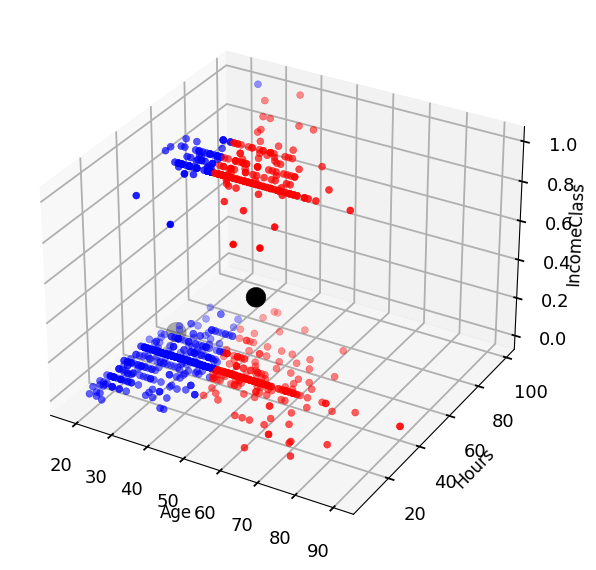

In [25]:
print("K-Means")
train = pd.DataFrame()
data = df.iloc[0:1000]
train["age"] = data["age"]
train["hours per week"] = data["hours per week"]
train["IncomeClass"] = data["IncomeClass"]
modelo = KMeans(2, True)

modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 100), random.uniform(0, 1)])
modelo.centroides.append([random.uniform(0, 100), random.uniform(0, 100), random.uniform(0, 1)])

print("Centroides Iniciales")
print("Centroide ", str(0), ":", str(modelo.centroides[0]))
print("Centroide ", str(1), ":", str(modelo.centroides[1]))

modelo.fit(train, distancia_minkowski , r=2)

red  = [[], [], []]
blue = [[], [], []]
black = [[], [], []]

print("Centroides finales")
for i in range(len(modelo.centroides)):
    print("Centroide ", str(i), ":", str(modelo.centroides[i]), " ---> black")
    black[0].append(modelo.centroides[i][0])
    black[1].append(modelo.centroides[i][1])
    black[2].append(modelo.centroides[i][2])

print("Clasificacion de las instancias")
print("Red -> Cluster 0")
print("Blue -> Cluster 1")
for i in range(len(modelo.C)):
    #print("Instancia", str(i), ":", modelo.C[i], end=" ---> \n")
    r = train.iloc[i].tolist()
    if(modelo.C[i] == 0):
        #print("red")
        red[0].append(r[0])
        red[1].append(r[1])
        red[2].append(r[2])
    else:
        #print("azul")
        blue[0].append(r[0])
        blue[1].append(r[1])
        blue[2].append(r[2])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(red[0], red[1], red[2], color='red', s=25)
ax.scatter(blue[0], blue[1], blue[2], color='blue',s=25)
ax.scatter(black[0], black[1], black[2], color='black',s=200)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Hours', fontsize=12)
ax.set_zlabel('IncomeClass', fontsize=12)
plt.rc('font', size=8)
plt.show(6,6)

## Ejemplo 4: KNN
Para este ejemplo, se utilizan 1000 filas y las variables "age", "education", "hours per week" y como variable clase "IncomeClass". Con K = 35.

In [26]:
hide_toggle(1)

KNN algorithm
Red  ->   <=50K
Blue ->   >50K
Education
0 :  Bachelors
1 :  Doctorate
2 :  HS-grad
3 :  Masters
4 :  Preschool
5 :  Prof-school
6 :  Some-college
Predicion 1 con [Age: 46, Education:  Bachelors, Hours: 72]:  >50K
Predicion 2 con [Age: 56, Education:  Preschool, Hours: 52]:  <=50K
Predicion 3 con [Age: 67, Education:  Prof-school, Hours: 59]:  <=50K
Predicion 4 con [Age: 68, Education:  Bachelors, Hours: 76]:  <=50K
Predicion 5 con [Age: 58, Education:  Preschool, Hours: 97]:  <=50K
Predicion 6 con [Age: 32, Education:  Doctorate, Hours: 64]:  <=50K
Predicion 7 con [Age: 28, Education:  Some-college, Hours: 32]:  <=50K
Predicion 8 con [Age: 34, Education:  Preschool, Hours: 35]:  <=50K
Predicion 9 con [Age: 100, Education:  Bachelors, Hours: 30]:  <=50K
Predicion 10 con [Age: 39, Education:  HS-grad, Hours: 6]:  <=50K
Predicion 11 con [Age: 69, Education:  Preschool, Hours: 21]:  <=50K
Predicion 12 con [Age: 98, Education:  Bachelors, Hours: 16]:  <=50K
Predicion 13 con [

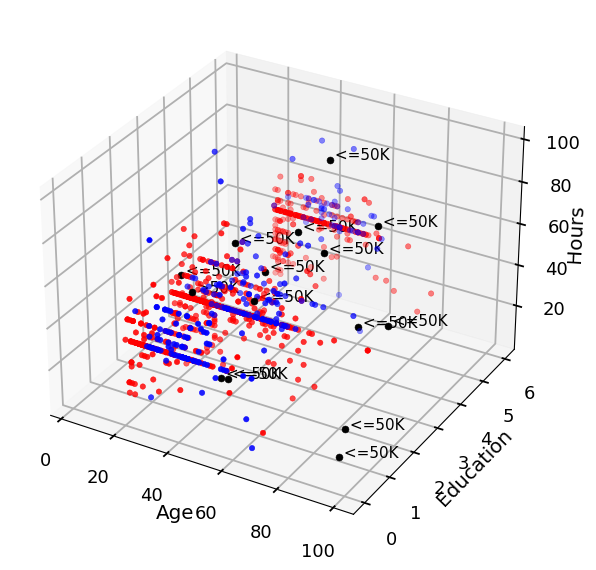

In [27]:
print("KNN algorithm")

values_ed= {2: ' HS-grad', 0: ' Bachelors', 3: ' Masters', 6: ' Some-college', 1: ' Doctorate', 5: ' Prof-school', 4: ' Preschool'}
values_ic = {0: ' <=50K', 1: ' >50K'}
    
train = pd.DataFrame()
data = df.iloc[0:1000]
train["age"] = data["age"]
train["hours per week"] = data["hours per week"]
train["education"] = data["education"]
train["IncomeClass"] = data["IncomeClass"]
modelo2 = KNN(35)
modelo2.fit(train,["age", "education"], "IncomeClass")

d0 = train[train["IncomeClass"] == 0]
d1 = train[train["IncomeClass"] == 1]

print("Red  -> ", values_ic[0])
print("Blue -> ", values_ic[1])
print("Education")
for i in range(len(values_ed)):
    print(i, ":", values_ed[i])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d0["age"].tolist(), d0["education"].tolist(), d0["hours per week"].tolist(), color = "red", s=15)
ax.scatter(d1["age"].tolist(), d1["education"].tolist(), d1["hours per week"].tolist(), color = "blue", s=15)

for i in range(15):
    features = [random.randint(0, 100), random.randint(0, 6), random.randint(0, 100)]
    ax.scatter(features[0], features[1], features[2], color = "black", s=25)
    value = modelo2.predict(features, distancia_minkowski, r=2)
    print("Predicion {} con [Age: {}, Education: {}, Hours: {}]: {}".format(i+1, features[0], values_ed[features[1]], features[2], values_ic[value]))
    ax.text(features[0], features[1], features[2], values_ic[value], fontsize=11)
    #ax.annotate(values_ic[value], xy =(features[0],features[1]), xytext=(features[0],features[1]))
ax.set_xlabel('Age')
ax.set_ylabel('Education')
ax.set_zlabel('Hours')
plt.show(10,10)

# Experimento - Supervisado
Se trabaja con el mismo dataset, separandolo un dataset de entrenamiento y otro de prueba. Asimismo se eligen las siguientes caracteristicas:
- Age.
- WorkClass
- Education.
- Race.
- Gender.
- Hours per week.

En cuanto a la variable clase definimos a:
- IncomeClass

Colocando en contexto, de acuerdo a las caracteristicas definidas poder determinar si una persona gana menos de 50 mil al año ().

In [28]:
hide_toggle(1)

In [29]:
train = pd.read_csv("train.csv")
train = train.drop(['marital status'], axis=1)
test = pd.read_csv("test.csv")
test = test.drop(['marital status'], axis=1)
display(train)
display(test)

,age,wc,education,race,gender,hours per week,IncomeClass
0,38,3,2,4,1,40,0
1,28,3,0,2,0,40,0
2,37,3,3,4,0,40,0
3,31,3,3,4,0,50,1
4,42,3,0,4,1,40,1
...,...,...,...,...,...,...,...
14835,39,3,2,4,1,40,1
14836,32,0,2,2,0,40,0
14837,18,3,6,4,0,20,0
14838,27,3,3,4,1,40,0


,age,wc,education,race,gender,hours per week,IncomeClass
0,67,3,0,4,1,40,1
1,21,3,2,4,1,40,0
2,31,3,2,4,1,40,0
3,29,3,0,4,1,40,1
4,28,3,0,4,1,40,1
...,...,...,...,...,...,...,...
4942,53,3,3,4,1,40,1
4943,22,3,6,4,1,40,0
4944,40,3,2,4,1,40,1
4945,58,3,2,4,0,40,0


## Implementacion de la Red Bayesiana

In [30]:
hide_toggle(1)

In [31]:
import pandas as pd
import numpy as np
import math
import random
import copy

# Esta función recive el nombre del archivo CSV y devuelve un dataframe de Pandas
def leer_dataset(nom_archivo):
    return pd.read_csv(nom_archivo)
# Retorna la lista de valores únicos de una columna de un dataframe
def cardinalidad(df, X):
    return df[X].unique()
#retorna el número de instancias de un dataframe que satisface una determinada condición.
def count(dataframe, index_list, values_list):
    resultado = dataframe
    for i in range(len(index_list)):
        #Se obtiene el nombre de la columna y el valor
        index = index_list[i]
        value = values_list[i]

        #Se filtra las filas que cumplen con la condicion de esa columna
        resultado = resultado[resultado[index] == value]
    #Devuelve el numero de instancias
    c =resultado.shape[0]
    return c

# Esta funcióm devuelve un reporte del factor que contiene a la variable X
def estimar_marginal(df,X, alpha):
    card = cardinalidad(df,X) # lista de valores únicos

    nfilas = df.shape[0]

    probList = []
    for valor in card:
        m = count(df,[X],[valor])
        p = (m + alpha)/(nfilas + len(card)*alpha)
        probList.append(p)
    probColName = "P"
    columns = {X:card, probColName: probList}

    return pd.DataFrame(columns)

def estimar_conjunta(df,variables,alpha):
    card = {}
    nfilas = 1

    ## filas en el df
    n = df.shape[0]

    for var in variables:
        card[var] = cardinalidad(df,var)
        nfilas = nfilas*len(card[var])

    columns = {}

    n_rep = 1
    for var, cardinal in card.items():
        columns[var] = [ cardinal[int(i/n_rep)%len(cardinal)] for i in range(nfilas) ]
        n_rep = n_rep * len(cardinal)

    result = pd.DataFrame(columns)

    probList = []

    #Iteramos por cada fila del dataframe y hallamos la probabilidad condicional
    for i in result.index:
        valores = []
        for var in variables:
            valores.append(result[var][i])

        n_intersection = count(df,variables,valores)

        p = (n_intersection + alpha)/ ( n + n_rep*alpha)

        probList.append(p)

    result['P'] = probList
    return result

def estimar_condicional(df, X, Y, alpha):
    # hallar el número total de filas 
    nFilasResult = 1
    nfilas = df.shape[0]
    cardTarget = cardinalidad(df,X)
    nFilasResult = nFilasResult*len(cardTarget)
    
    cardY = {}
    for var in Y:
        cardY[var] = cardinalidad(df,var)
        nFilasResult = nFilasResult*len(cardY[var])
    
    columns = {}
    
    n_rep = 1
    
    colTarget = [cardTarget[i%len(cardTarget)] for i in range(nFilasResult)]
    
    columns[X] = colTarget
    n_rep = n_rep * len(cardTarget)
    
    for var, card in cardY.items():
        columns[var] = [ card[int(i/n_rep)%len(card)] for i in range(nFilasResult) ]
        
        n_rep = n_rep * len(card)

    
    result = pd.DataFrame(columns)
    probList = []
    
    prodCardY = 1
    for var in Y:
        prodCardY = prodCardY* len(cardY[var])
        
    #Iteramos por cada fila del dataframe y hallamos la probabilidad condicional
    for i in result.index:
        valTarget = result[X][i]
    
        valPadres = []
        for var in Y:
            valPadres.append(result[var][i])
      
        totalVar = [i for i in Y]
        totalVar.append(X)
        totalVal = valPadres
        totalVal.append(valTarget)
        
        
        prob_X_Y = (count(df,totalVar,totalVal) + alpha) / (nfilas + prodCardY*len(cardTarget)*alpha) 
        
        prob_Y = (count(df,Y,valPadres) + alpha) / (nfilas + prodCardY*alpha)
        p = prob_X_Y/prob_Y
        probList.append(p)
    
    # normalizamos las probabilidades
    for i in range(int (nFilasResult / len(cardTarget))):
        suma = 0
        for j in range(len(cardTarget)):
            suma = suma + probList[i*len(cardTarget) + j]
        
        for j in range(len(cardTarget)):
            probList[i*len(cardTarget) + j] = probList[i*len(cardTarget) + j] / suma 
    
    result['P'] = probList
    return result

class Preprocessor:
    def __init__(self, df ,alpha):
        self.variables = self.get_vars(df)
        self.alpha = alpha
        self.df = df
        self.card = self.get_cards(df)
        self.marg_cond = self.preprocess(df)
        self.conj = self.calcular_conjunta(df)
        self.instancias = len(df.index)

    def get_cards(self, df):
        nodes = self.variables
        card = {}
        for value in nodes:
            card[value] = df[value].unique()
        return card

    def get_vars(self,df):
        variables = []
        for i in df:
            variables.append(i)

        return variables

    def calcular_conjunta(self,df):
        prob = {}

        #calcular las conjunta de cada par de variables diferentes
        for variable_1 in self.variables:
            for variable_2 in self.variables:
                if (variable_1 == variable_2):
                    continue
                prob[tuple([variable_1, variable_2])] = estimar_conjunta(df,[variable_1,variable_2], self.alpha)
        return prob

    #preprocesa las marginales y las condicionales para cada para de variables
    def preprocess(self,df):
        prob = {}

        #calcular las marginales de todas la variables
        for variable in self.variables:
            prob[tuple([variable])] = estimar_marginal(df,variable,self.alpha)

        #calcular las condicionales de cada par de variables diferentes
        for variable_1 in self.variables:
            for variable_2 in self.variables:
                if (variable_1 == variable_2):
                    continue
                prob[tuple([variable_1, variable_2])] = estimar_condicional(df,variable_1, [variable_2], self.alpha)
        return prob


    def get_preprocess_marginal(self, variable, valor):
        resultado = self.marg_cond[(variable,)]
        resultado = resultado[resultado[variable]==valor]
        return list(resultado['P'])[0]

    def get_preprocess_conjunta(self, variables, valores):
        resultado = self.conj[variables]
        for i in range(2):
            index = variables[i]
            value = valores[i]
            #filtrar la columna
            resultado = resultado[resultado[index] == value]

        return list(resultado['P'])[0]

    def get_preprocess_condicional(self, factor, valores):
        resultado = self.marg_cond[factor]
        for i in range(2):
            index = factor[i]
            value = valores[i]
            #filtrar la columna
            resultado = resultado[resultado[index] == value]
        return list(resultado['P'])[0]

# Retorna los padres de los nodos
def get_parents(grafo):
    result = {}
    
    for node, list_adyacentes in grafo.items():
        if node not in result:
            result[node] = set()
        
        if (len(list_adyacentes) > 0):  
            for child in list_adyacentes:
                if child not in result:
                    result[child] = set()
                    result[child].add(node)
                else:
                    result[child].add(node)
    
    return result

class Red_Bayesiana:
    def __init__(self, df, grafo, alpha, preprocessor = None):
        self.alpha = alpha
        self.estructura = grafo
        self.parents = get_parents(self.estructura)
        self.factores = self.generate(df)
       
        self.card = self.get_cards(df)
        self.preprocessor = preprocessor
        
    def get_cards(self, df):
        nodes = self.estructura.keys()
        card = {}
        for value in nodes:
            card[value] = df[value].unique()
        return card
    #Genera todos los factores de acuerdo a la estructura
    def generate(self, df):
        factores = {}
        parents = self.parents
        for child, parent_list in parents.items():
            if (len(parent_list) == 0):
                
                factores[tuple([child])] = estimar_marginal(df,child, self.alpha)
            else:
                key = list(parent_list)
                key.insert(0, child)
                key = tuple(key)
                factores[key] = estimar_condicional(df,child, list(parent_list), self.alpha)
        return factores
    
    def printFactores(self):
        print("Factores del grafo")
        for key, df in self.factores.items():
            
            if (len(key)==1):
                print ("P(" + key[0] + ")", end=" ")
            else:
                s = None
                for i in range(len(key)):
                    if (i==0):
                        s = "P(" + key[0] + "|"
                    elif(i == len(key) - 1):
                        s = s + key[i] + ")"
                    else:
                        s = s + key[i] + ","
                print (s, end=" ")
                
    #Función para calcular todos los ancestros de un nodo
    def get_all_ancestor(self, current, current_parents, amount_of_ancestors, visited):
        visited[current] = True
        for parent in current_parents:
            if(not visited[parent]):
                self.get_all_ancestor(parent, self.parents[parent], amount_of_ancestors, visited)
            amount_of_ancestors[current] = amount_of_ancestors[current] + amount_of_ancestors[parent] + 1
        
    #Devuelve las variables ocultas ordenados en orden topológico
    def get_hidden_variables(self, consulta, evidencia):
        nodes = self.estructura.keys()
        amount_of_ancestors = {}
        visited = {}
        
        for node in nodes:
            visited[node] = False
            amount_of_ancestors[node] = 0
        
        for node in nodes:
            if(not visited[node]):
                self.get_all_ancestor(node, self.parents[node], amount_of_ancestors, visited)
        
        hidden_variables = []
        for variable in nodes:
            if ((variable not in evidencia) and variable != consulta):
                #Cada variable esta asociada a la cantidad de ancestros
                hidden_variables.append([variable, amount_of_ancestors[variable]])
        #Se ordena de menor a mayor de acuerdo a la cantidad de ancestros
        #Esto nos garantiza que el nodo que tiene padre va estar después de su padre
        hidden_variables = sorted(hidden_variables, key=lambda item: item[1])
        
        Z = []
        for i in hidden_variables:
            Z.append(i[0])
        return Z
    #El valor de la distribuicion marginal
    def estimar_marginal(self, factor, valores): 
        assert len(valores) == 1, "Marginal solo acepta un valor"
        #Se filtra el factor
        resultado = self.factores[factor]
        resultado = resultado[resultado[factor[0]]==valores[0]]
        return list(resultado['P'])[0]
    #El valor de la distribuicion condicional
    def estimar_condicional(self, factor, valores):
        #Se filtra el factor
        resultado = self.factores[factor]
        for i in range(len(factor)):
            index = factor[i]
            value = valores[i]
            #filtrar la columna 
            resultado = resultado[resultado[index] == value]
        return list(resultado['P'])[0]
   
        
    
def inferencia(clase, e_variables , e_values, red_bayesiana):
    
    var_val = {}
    
    for i in range(len(e_variables)):
        var_val[e_variables[i]] = e_values[i]
    
    # retorna un diccionario con llaves los nodos y valores 
    parentsList = red_bayesiana.parents
    
    #Cardinalidad de la variable clase
    card = red_bayesiana.card[clase]
    list_prob = []
    
    for valor in card:
        p = 1
        var_val[clase] = valor
        for var, parents in parentsList.items():
            if (len(parents) == 0):
                p = p * red_bayesiana.estimar_marginal((var,),[var_val[var]] )
             
            else:
                
                values = [var_val[var]]
                
                for parent in parentsList[var]:
                    values.append(var_val[parent])

                key = list(parentsList[var])
                key.insert(0,var)
                key = tuple(key)
                p = p * red_bayesiana.estimar_condicional(key,values)
      
        list_prob.append(p)
    
    columns = {}
    
    columns[clase] = card
    columns['P'] = list_prob
    
    return pd.DataFrame(columns)


def predict(clase, e_variables , e_values, red_bayesiana):
    var_val = {}
    
    for i in range(len(e_variables)):
        var_val[e_variables[i]] = e_values[i]
    
    # retorna un diccionario con llaves los nodos y valores 
    parentsList = red_bayesiana.parents
    
    #Cardinalidad de la variable clase
    card = red_bayesiana.card[clase]
    list_prob = []
    
    for valor in card:
        p = 1
        var_val[clase] = valor
        for var, parents in parentsList.items():
            if (len(parents) == 0):
                p = p * red_bayesiana.estimar_marginal((var,),[var_val[var]] )
             
            else:
                
                values = [var_val[var]]
                
                for parent in parentsList[var]:
                    values.append(var_val[parent])

                key = list(parentsList[var])
                key.insert(0,var)
                key = tuple(key)
                p = p * red_bayesiana.estimar_condicional(key,values)
      
        list_prob.append(p)
    
    return max(list_prob)



def get_scope(factores, variable):
    factores_with_variable = []
    factores_without_variable = []
    for factor in factores:
        if(variable in factor):
            factores_with_variable.append(factor)
        else:
            factores_without_variable.append(factor)
    return (factores_with_variable, factores_without_variable)

def get_vars(phi_prima):
    involved = []
  
    for element in phi_prima:
        for value in element:
            if(value not in involved):
                involved.append(value)
  
    return involved

def sum_product_eliminate_var(factores, variable_to_eliminate, consulta, valor_consulta, evidencia, valor_evidencia , red_bayesiana ):
    # factores que se van a factorizar
    
    phi_prima, phi_prima_prima = get_scope(factores,variable_to_eliminate)
      
    # lista de variables involucradas en phi_prima
    variables_in_scope = get_vars(phi_prima)

    #diccionario: llave -> variable , valor -> lista de cardinalidad
    var_to_values = {}
    
    for var in variables_in_scope:
        if (var != consulta and (var not in evidencia)):
            var_to_values[var] = red_bayesiana.card[var]
    var_to_values[consulta] = [valor_consulta]
    
    for i in range(len(evidencia)):
        var_to_values[evidencia[i]] = [valor_evidencia[i]]
    
    # llave: variable , valor --> indice en una n_upla
    var_to_index = {}

    #total number of posibilites
    n =  1
    for var, val in var_to_values.items():
        n = n*len(val)
  
    posibilidades =  []
    for i in range(n):
        posibilidades.append([])
        
    groups = 1
    pos = 0
    for var in variables_in_scope:
        var_to_index[var] = pos
        pos = pos + 1
        values = var_to_values[var]
        m = len(values)
        groups = groups*m
        rep = int(n/groups)
        for i in range(groups):
            for j in range(rep):
                posibilidades[i*rep + j].extend([values[i%m]])
    # factores que quedan
  
    p = 0 
    # iterar entre todas las posibilidades
    for n_upla in posibilidades:
    
        p_local = 1
        for dist in phi_prima:
            var = dist[0] # El nodo
            cond = dist[1:] # Los padres del nodo
            
            # hallar los valores que tomas las variables en la distribuiciones
            if (len(cond) == 0):
                p_marginal = red_bayesiana.estimar_marginal(dist,[n_upla[var_to_index[var]]])
                p_local = p_local*p_marginal
            else:
                valores = []
                for var in dist:
                    index = var_to_index[var]
                    valores.append(n_upla[index])
                
                p_condicional = red_bayesiana.estimar_condicional(dist, valores)
              
                p_local = p_local*p_condicional
        # sumatoria de los valores en los factores dentro del get_scope
        p = p + p_local
        
    return [phi_prima_prima, p]

def sum_product(factores, consulta, valor_consulta, evidencia, valor_evidencia, red_bayesiana):
    
    var_to_val = {}
    for i in range(len(evidencia)):
        var_to_val[evidencia[i]] = valor_evidencia[i]
    
    var_to_val[consulta] = valor_consulta
    
    p = 1
    
    for dist in factores:
        var = dist[0]
        cond = dist[1:]
        if (len(cond) == 0):
            p_marginal = red_bayesiana.estimar_marginal(dist,[var_to_val[var]])
            p = p*p_marginal
        else:
            valores = []
            for var in dist:
                valores.append(var_to_val[var])
         

            p_condicional = red_bayesiana.estimar_condicional(dist, valores)
           
            p = p*p_condicional
    
    return p

def sum_product_ve(consulta, valor_consulta , evidencia, valor_evidencia, red_bayesiana):
    Z = red_bayesiana.get_hidden_variables(consulta, evidencia)
  
    tetha = []
    factores = red_bayesiana.factores.keys() # lista de factores
    for i in range(len(Z)):
  
        
        if(len(factores) == 0):
            break
        [nuevos_factores,sumatoria] =  sum_product_eliminate_var(factores, Z[i], consulta, 
                                                                 valor_consulta, evidencia, 
                                                                 valor_evidencia, red_bayesiana)
    
        factores = nuevos_factores
        tetha.append(sumatoria)
    
    if(len(factores)>0):
        p_last = sum_product(factores,consulta,  valor_consulta, evidencia,valor_evidencia, red_bayesiana)
        tetha.append(p_last)
    p = 1
    for sumatoria in tetha:
        p = p*sumatoria
    
    return p

def inferencia_con_variables_ocultas(consulta, evidencia, valor_evidencia, red_bayesiana):
    
    card = red_bayesiana.card[consulta]
    list_prob = []
    for valor_consulta in card:
        p = sum_product_ve(consulta, valor_consulta , evidencia, valor_evidencia, red_bayesiana)
        list_prob.append(p)
    columns = {}
    columns[consulta] = card
    columns['P'] = list_prob
    
    return pd.DataFrame(columns)

class Structure:
    def __init__(self, list_adj ,preprocessor = None):
        self.estructura = copy.deepcopy(list_adj)
        self.parents = get_parents(self.estructura)
        self.set_edge = self.get_set_edge(list_adj)
        self.n_nodes = len(list_adj.keys())
        self.n_edges = len(self.set_edge)
        self.nodes_indexes = self.get_indexes()
        self.graph_id = self.get_graph_id()
        self.edges_not_graph = self.get_edges_not_graph()
        self.preprocessor = preprocessor

    def get_indexes(self):
        indexes = {}
        i = 0
        for node in self.estructura.keys():
            indexes[node] = i
            i = i + 1
        return indexes

    def get_graph_id(self):
        VxV = self.n_nodes * self.n_nodes
        g_id = [0] * (VxV)
        for node, list_adj in self.estructura.items():
            for neighbor in list_adj:
                index = self.n_nodes * self.nodes_indexes[node] + self.nodes_indexes[neighbor]
                g_id[index] = 1
        return g_id

    def get_set_edge(self, list_adj):
        result = set()
        for v, list_neighbors in list_adj.items():
            for neighbor in list_neighbors:
                result.add((v,neighbor))
        return result

    def get_edges_not_graph(self):
        edges_possibles = set()
        i = 0
        j = self.n_nodes - 1
        k = 0
        nodes = list(self.nodes_indexes.keys())
        for index in range(len(self.graph_id)):
            if(index != i):
                if(self.graph_id[index] == 0):
                    edges_possibles.add((nodes[i%self.n_nodes], nodes[k%self.n_nodes]))
            if(j == index):
                i = i + self.n_nodes + 1
                j = j + self.n_nodes

            k = k + 1

        return edges_possibles

    def add_edge(self,v1,v2):
        edge = (v1, v2)
        self.edges_not_graph.remove(edge)
        self.set_edge.add(edge)

        self.estructura[v1].append(v2)
        self.parents[v2].add(v1)
        self.n_edges = self.n_edges + 1

        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 1 # this means that a edge was added

    def operator_for_eliminate_edge(self):
        if (self.n_edges == 0):
            return
        edge = random.choice(list(self.set_edge))
        self.set_edge.remove(edge)
        self.edges_not_graph.add(edge)

        v1 = edge[0]
        v2 = edge[1]
        self.estructura[v1].remove(v2)
        self.parents[v2].remove(v1)
        self.n_edges = self.n_edges - 1

        #Update graph id
        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 0 # this means that a edge was removed
        return edge

    def operator_for_add_edge(self):
        total_edges = (self.n_nodes) * (self.n_nodes - 1)
        if(total_edges == len(self.set_edge)):
            return

        edge = random.choice(list(self.edges_not_graph))
        self.edges_not_graph.remove(edge)
        self.set_edge.add(edge)
        v1 = edge[0]
        v2 = edge[1]
        self.estructura[v1].append(v2)
        self.parents[v2].add(v1)

        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 1 # this means that a edge was added

        self.n_edges = self.n_edges + 1

    def operator_for_reverse_edge(self):
        total_edges = (self.n_nodes) * (self.n_nodes - 1)
        if (self.n_edges == 0 or self.n_edges == total_edges):
            return

        possible = False
        inverted_edge = None
        edge_to_remove = None
        for graph_edge in self.set_edge:
            inverted = (graph_edge[1], graph_edge[0])
            if (not (inverted in self.set_edge)):
                edge_to_remove = graph_edge
                inverted_edge = inverted
                possible = True
                break

        if(not possible):
            return

        self.set_edge.remove(edge_to_remove)
        self.edges_not_graph.add(edge_to_remove)

        v1 = edge_to_remove[0]
        v2 = edge_to_remove[1]
        self.estructura[v1].remove(v2)
        self.parents[v2].remove(v1)

        v1 = inverted_edge[0]
        v2 = inverted_edge[1]
        self.estructura[v1].append(v2)
        self.parents[v2].add(v1)

        self.set_edge.add(inverted_edge)
        self.edges_not_graph.remove(inverted_edge)

        index = self.n_nodes*self.nodes_indexes[v1] + self.nodes_indexes[v2]
        self.graph_id[index] = 1 # this means that a edge was added
        index = self.n_nodes*self.nodes_indexes[v2] + self.nodes_indexes[v1]
        self.graph_id[index] = 0 # this means that a edge was removed

    def is_cyclic_util(self, v, visited, recStack):
        visited[v] = True
        recStack[v] = True

        for neighbour in self.estructura[v]:
            if(not visited[neighbour]):
                if (self.is_cyclic_util(neighbour, visited, recStack)):
                    return True
            elif (recStack[neighbour]):
                return True

        recStack[v] = False
        return False

    def is_cyclic(self):
        nodes = self.estructura.keys()
        visited = {}
        recStack = {}
        for node in nodes:
            visited[node] = False
            recStack[node] = False

        for node in nodes:
            if (not visited[node]):
                if self.is_cyclic_util(node, visited, recStack):
                    return True

        return False

def get_entropia(estructura_red):
    ## Obtenemos la cardinalidad de cada variable
    variables = estructura_red.estructura.keys()
    n = len(variables)
    # diccionario de variable -> lista de valores

    r = {}
    for var in variables:
        r[var] = estructura_red.preprocessor.card[var]


    # diccionario de variables -> lista de padres
    q = estructura_red.parents
    #TO DO

    # N total de instancias
    N = estructura_red.preprocessor.instancias
    result = 0

    # i = 1 ... n
    # xi
    for variable in variables:
        xi = variable
        pa_xi = list(q[variable])

        # si la variable no tiene padre
        if(len(pa_xi)==0):
            for valor in r[variable]:

                # Ej: P(A = 0).log2(P(A=0))
                prob_xi = estructura_red.preprocessor.get_preprocess_marginal(xi, valor)
                result = result + prob_xi*math.log(prob_xi,2)

            continue

        # j = 1 .... qi
        pa_xi = pa_xi[0]
        for parent_val in r[pa_xi]:
            # k = 1... ri
            for valor in r[variable]:
                # Calculo de P(xi|pa(xi))
                p_xi_paxi = estructura_red.preprocessor.get_preprocess_condicional((xi,pa_xi),[valor,parent_val])
                p_conj_xi_pxi = estructura_red.preprocessor.get_preprocess_conjunta((xi,pa_xi),[valor,parent_val])

                result = result + p_conj_xi_pxi*(math.log(p_xi_paxi,2))

    result = result*(-1)*N

    return result

def get_number_independent_parameters(estructura_red):
    cardinalities = estructura_red.preprocessor.card
    parents = estructura_red.parents

    sum = 0

    for r in cardinalities.keys():
        q = 1
        for parent in parents[r]:
            q = q * len(cardinalities[parent])
        sum = sum + (len(cardinalities[r]) - 1)*q

    return sum

def get_akaike(estructura_red):
    #
    K = get_number_independent_parameters(estructura_red)
    e = get_entropia(estructura_red)

    return e + K

def get_mdl(estructura_red):
    N = estructura_red.preprocessor.instancias
    K = get_number_independent_parameters(estructura_red)
    e = get_entropia(estructura_red)

    return e + K/2*math.log(N,2)

def get_k2(estructura_red):
    # Obtenemos la cardinalidad de cada variable
    variables = estructura_red.preprocessor.variables
    n = len(variables)
    df = estructura_red.preprocessor.df
    q = estructura_red.parents

    r = {}
    for var in variables:
        r[var] = estructura_red.preprocessor.card[var]

    result = 1

    for variable in variables:
        xi = variable
        pa_xi = list(q[variable])
        if(len(pa_xi)==0):
            continue

        ri = len(r[variable])

        # j = 1 .... qi
        pa_xi = pa_xi[0]
        for parent_val in r[pa_xi]:

            # Nij número de instancias donde Pa(xi) toma su j-esimo valor
            Nij = count(df, [pa_xi], [parent_val])


            a = math.factorial(ri -1) / math.factorial(ri-1 + Nij)

            result = result*a
            # k = 1... ri
            for valor in r[variable]:

                # Nijk número de instancias donde Pa(xi) toma su j-esimo valor y xi toma su k-esimo valor
                Nijk = count(df, [pa_xi,xi],[parent_val,valor])
                result =  result* math.factorial(Nijk)

    return result

def greedy_local_search_modified(initial_solution, score_function, set_operators = [0, 1, 2]):
    best_solution = initial_solution
    Progress = True
    iteraciones = 0
    while(Progress):
        solution = best_solution
        Progress = False
        for operator in set_operators:
            candidate_solution = copy.deepcopy(solution)
            if(operator == 0):
                candidate_solution.operator_for_add_edge()
            elif(operator == 1):
                candidate_solution.operator_for_eliminate_edge()
            else:
                candidate_solution.operator_for_reverse_edge()

            iteraciones = iteraciones + 1
            if (not candidate_solution.is_cyclic()):
                if(score_function(candidate_solution) > score_function(best_solution)):
                    best_solution = copy.deepcopy(candidate_solution)
                    Progress = True
    return (best_solution, iteraciones)

def greedy_algorithm_search_space(initial_graph, score_function):
    N = initial_graph.n_nodes
    MAX_ITERACIONES = 2**(N*(N-1)) * 0.25
    print(MAX_ITERACIONES)
    MAX = 5
    graph = copy.deepcopy(initial_graph)
    g_id = initial_graph.graph_id
    same_id = 0
    current_iteration = 0
    while(current_iteration < MAX_ITERACIONES):
        while(current_iteration < MAX_ITERACIONES and same_id < MAX):
            graph, iteraciones = greedy_local_search_modified(graph, score_function, [0, 1, 2])
            current_iteration = current_iteration + iteraciones
            print("*******************")
            print(graph.estructura)
            print(current_iteration)
            print("*******************")
            if(graph.graph_id == g_id):
                same_id = same_id + 1
            else:
                g_id = graph.graph_id
                same_id = 0

        if(current_iteration < MAX_ITERACIONES):
            new_graph = graph
            candidate_graph = copy.deepcopy(new_graph)
            cant = 3
            op = random.randint(0,2)
            if(op == 0):
                for i in range(cant):
                    candidate_graph.operator_for_add_edge()
                    if(not candidate_graph.is_cyclic()):
                        new_graph = candidate_graph
                    candidate_graph = copy.deepcopy(new_graph)

            elif(op == 1):
                for i in range(cant):
                    graph.operator_for_eliminate_edge()
                    if(not candidate_graph.is_cyclic()):
                        new_graph = candidate_graph
                    candidate_graph = copy.deepcopy(new_graph)
            else:
                for i in range(cant):
                    graph.operator_for_reverse_edge()
                    if(not candidate_graph.is_cyclic()):
                        new_graph = candidate_graph
                    candidate_graph = copy.deepcopy(new_graph)
            print("nuevo grafo")
            print(graph.estructura)
            same_id = 0
            current_iteration = current_iteration + cant
            graph = new_graph


    return current_iteration


## Implementacion de la Red Neuronal

In [32]:
hide_toggle(1)

In [33]:

import math, random

class NeuralNetwork():
    def __init__(self, n_entradas, n_salidas , capas = [] ):
        self.n_entradas = n_entradas
        self.n_salidas =  n_salidas
        self.n_capas = len(capas) + 2 #la capa de entrada + capas ocultas + la capa de salida

        self.bias = {}
        self.Z = {}
        self.error = {}
        self.capas = self.generate_capas(capas)
        self.W = self.generate_weights() 

    def generate_capas(self, capas):
        result = {}
        idx = 1
        #capa de entrada, esta sería la capa con indice 0
        #Estas como no son neuronas, solo es necesario asignar un ID
        result[0] = []
        for i in range(self.n_entradas):
            result[0].append(idx)
            idx += 1
        # capas ocultas, estan van desde en el intervalo de indices [1 - n_capas-2]
        # Aqui se encuentran las neuronal por lo que hay que mapearlas con un
        # identificador
        # Los identificadores de cada neurona se agregan en una lista, la cual representa
        # la capa que pertenecen
        for i in range(len(capas)):
            result[i+1] = []
            for j in range(capas[i]):
                # se genera el bias entre el intervalo [-0.1, 0.1]
                self.bias[idx] = random.uniform(-0.1,0.1)
                self.Z[idx] = 0
                self.error[idx] = 0
                result[i+1].append(idx)
                idx += 1
        #capa final, esta sería la capa con indice n_capas-1
        result[self.n_capas - 1] = []
        for i in range(self.n_salidas):
            # se genera el bias entre el intervalo [-0.1, 0.1]
            self.bias[idx] =random.uniform(-0.1,0.1)
            self.Z[idx] = 0
            self.error[idx] = 0
            result[self.n_capas - 1].append(idx)
            idx += 1
        return result

    #genera pesos aleatorios en el intervalo [-1, 1]
    def generate_weights(self):
        weights = {}

        for i in range(self.n_capas - 1):
            capa_i = self.capas[i]
            capa_ip1 = self.capas[i+1]
            #Los pesos de las aristas se le asigna un identificador como tupla
            for a in capa_i:
                for b in capa_ip1:
                    weights[(a,b)] = random.uniform(-1,1)
        return weights
    
    #Se obtiene el resultado de las neuronas que se encuentran en la capa de salida para ello
    #nos apoyamos de la funcion level_output la cual de manera recursiva obtiene los resultados de
    #las neuronas de la capa anterior.
    def fordward_propagation(self, X, Y):
        capa_final = self.capas[self.n_capas - 1]
        for i in range(len(capa_final)):
            p = self.level_output(self.n_capas - 1,capa_final[i],X)
 
            self.error[capa_final[i]] = Y[i] - p
        return 
    
    #Para obtener la salida de cada neurona (Z) se realiza de manera recursiva
    #El caso base es al encontrarnos en la capa 1, ya que la capa 0 es la capa de entrada
    #Por lo que se utiliza las funciones propias de una neurona.
    #En caso contrario tendriamos el valor Z_i de las neuronas de la capa anterior 
    #por lo que directamente se calcula la salida Z_j de la neurona actual con las aristas relacionadas a ella
    def level_output(self,capa, neurona_id, X):    
        sumatoria = 0
        if (capa == 1):
            for i in range(len(X)):
                sumatoria += X[i]*self.W[(i+1,neurona_id)]  

            y_prob = self.__sigmoide(sumatoria)
            self.Z[neurona_id] = y_prob
            return y_prob
        #Las aristas relacionada a la neurona están dadas con el identificador de la neurona actual y 
        #el ID de las neuronas de la capa anterior
        for neurona in self.capas[capa - 1]:
            sumatoria += self.level_output(capa - 1, neurona, X)*self.W[(neurona,neurona_id)]

        y_prob = self.__sigmoide(sumatoria) + self.bias[neurona_id]
        self.Z[neurona_id] = y_prob
        return y_prob
    #Se asigna el error de cada neurona de manera recursiva con apoyo de la función de abajo
    def retro_propagation(self):
        capa_inicial = self.capas[1]

        for neurona in capa_inicial:
            self.level_error(1,neurona)
  
    #Se asigna el error de cada neurona y se actualiza el bias
    #Esta funcion es recursiva, se llama a esta funcion para la capa siguiente.
    def level_error(self,capa, neurona_id):
        if (capa == self.n_capas - 1):
            #Este error fue asignado en forward_propagation
            return self.error[neurona_id]

        error = 0
        for neurona in self.capas[capa + 1]:
            error += self.level_error(capa + 1,neurona)*self.W[(neurona_id,neurona)]
        self.error[neurona_id] = error
        self.bias[neurona_id] += error*self.__gradiente(self.Z[neurona_id])
        return error
    #Esta funcion realizada la llamada de la funcion de abajo la cual es recursiva y es la encargada
    #de actualizar todos los pesos.
    #En esta funcion se realiza la llamada inicial con los identificadores de las neuronas de la capa final
    def update_weigths(self,X):
        capa_final = self.capas[self.n_capas - 1]

        for neurona in capa_final:
            self.level_update_weight(self.n_capas - 1, neurona,X)  
        return
    
    #Esta funcion es recursiva, la cual actualiza los pesos relacionados a una neurona en la capa i 
    #con las neuronas en la capa i-1
    #El caso base es cuando nos encontramos en la capa 1, ya que la capa 0 es la capa de entrada
    def level_update_weight(self, capa , neurona_id, X):
        if (capa == 1):
            for i in range(len(X)):
                self.W[(i+1, neurona_id)] +=   X[i]*self.error[neurona_id]*self.__gradiente(self.Z[neurona_id])  
            return

        for neurona in self.capas[capa - 1]:
            self.level_update_weight(capa - 1,neurona, X)  

        for neurona in self.capas[capa - 1]:
            self.W[(neurona, neurona_id)] += self.level_output(capa -1, neurona, X)*self.error[neurona_id]*self.__gradiente(self.Z[neurona_id])  

    def back_propagation(self,X, Y):
        self.fordward_propagation(X,Y)
        self.retro_propagation() #Se asigna el error de cada neurona y se actualiza el bias
        self.update_weigths(X) #Actualizar los pesos de acuerdo a lo anterior
    
    #Se obtiene el valor, la cual representa la prediccion de nuestra red neuronal
    def predict(self,X):
        y_proba = []
        capa_final = self.capas[self.n_capas - 1]
        #Si hay varias neuronas en la capa final, se obtienen todos los resultados
        for n in capa_final:
            p = self.level_output(self.n_capas - 1,n,X) + self.bias[n]
            y_proba.append(p)

        return y_proba  

    # Se entrena la red neuronal utilizando el algoritmo back propagation
    def fit(self, d_ent, epocas):
        for _ in range(epocas):
            for reg in d_ent:
                X = reg['X']
                Y = reg['Y']
                self.back_propagation(X,Y)

        return
    
    # Funciones propias de una neurona.
    def __sumatoria(self, X):
        suma = 0
        for i, x in enumerate(X):
            suma += self.W[i]*x
        return suma

    def __sigmoide( self, suma ):
        return 1/(1+math.exp(-suma))

    def __gradiente(  self, y_proba ):
        return y_proba*(1-y_proba)

# Inicialización: Red Neuronal
Se define la siguiente arquitectura

In [34]:
hide_toggle(1)

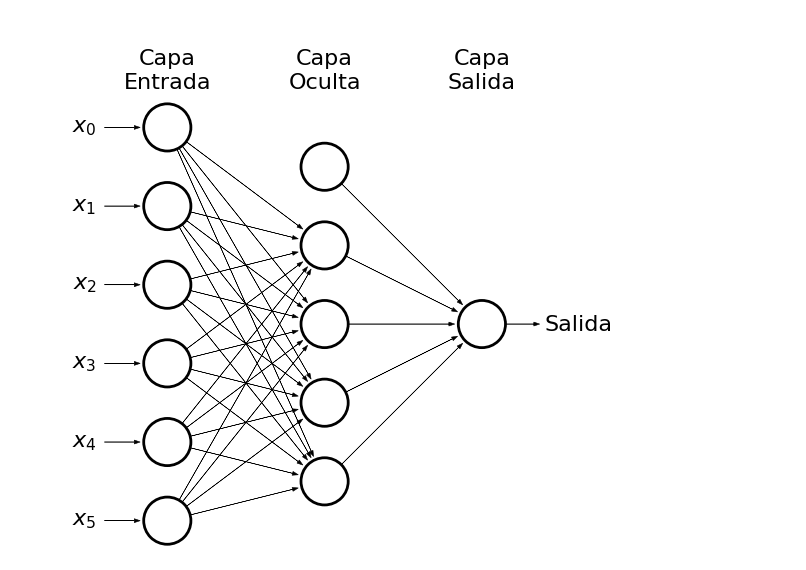

In [35]:
draw_net(6,1,[5], w=10, h=6)
rnadult = NeuralNetwork(6,1,[5])

## Entrenamiento: Red Neuronal

Adaptando el dataset de entrenamiento para que sea aceptado por la red neuronal

In [36]:
hide_toggle(1)

In [37]:
df_train = []
for i in range(train.shape[0]):
    elem = {}
    r = train.iloc[i].tolist()
    elem['Y'] = [r[-1]]
    elem['X'] = r[:len(r)-1]
    df_train.append(elem)

Se empieza a entrenar

In [38]:
hide_toggle(1)

In [39]:
rnadult.fit(df_train, 2)

## Fase de Test: Red Neuronal
Se empieza a testear nuestra red neuronal

In [40]:
hide_toggle(1)

In [41]:
y_rn = []
for i in range(test.shape[0]):
    r = test.iloc[i].tolist()
    X = r[:len(r)-1]
    valor1 = rnadult.predict(X)
    y_rn.append(round(valor1[0]))

## Inicialización: KNN
Se asigna el parametro K = 25

In [42]:
hide_toggle(1)

In [43]:
knnadult = KNN(25)

## Entrenamiento: KNN
Al ser aprendizaje perezoso, pasaremos como argumento el dataset, las caracteristicas y la variable clase.

In [44]:
hide_toggle(1)

In [45]:
knnadult.fit(train.iloc[0:250],["age", "wc", "education", "race", "gender", "hours per week"], "IncomeClass")

## Fase de Test: KNN

In [46]:
hide_toggle(1)

In [47]:
y_knn = []
for i in range(test.shape[0]):
    r = test.iloc[i].tolist()
    features = r[:len(r)-1]
    value = knnadult.predict(features, distancia_minkowski, r=2)
    y_knn.append(value)

# Metricas
Construimos la matriz de confusion De cada modelo

In [48]:
hide_toggle(1)

In [49]:
def construir_matriz_confusion( y_real, y_modelo, n_clases ):
    matriz = [ [0]*n_clases for _ in range(n_clases) ]
    M = len(y_real)
    for m in range(M):
        clase_real = y_real[m]
        clase_predecida = y_modelo[m]
        matriz[ clase_predecida ][ clase_real ] += 1
    return matriz

y_real = test["IncomeClass"].tolist()
m_confusion1 = construir_matriz_confusion(y_real, y_rn, 2)
m_confusion2 = construir_matriz_confusion(y_real, y_knn, 2)
#m_confusion3 = construir_matriz_confusion(y_real, predecidas, 2)
print("Matriz de confusion de la Red Neuronal")
for fila in m_confusion1:
    print(fila)
print("Matriz de confusion de KNN")
for fila in m_confusion2:
    print(fila)

Matriz de confusion de la Red Neuronal
[3591, 1356]
[0, 0]
Matriz de confusion de KNN
[3519, 1246]
[72, 110]


Debido al proceso de parser de la data, observamos lo siguiente

In [50]:
hide_toggle(1)

In [51]:
values_ic = {0: ' <=50K', 1: ' >50K'}
print(values_ic)

{0: ' <=50K', 1: ' >50K'}


Como queremos determinar que de acuerdo a un conjunto de caracteristicas si gana menos de 50 mil al año (<=50k), nuestra variable interés se encuentra en la posicion (0,0)

In [52]:
hide_toggle(1)

In [53]:
def accuracy_n(matriz_confusion):
  # nro de clases 
  n_clases = len(matriz_confusion)
  true_cases  = 0
  for i in range(n_clases):
    true_cases += matriz_confusion[i][i]
  total_cases = 0
  for fila in matriz_confusion:
    total_cases += sum(fila)
  return true_cases/total_cases

def precision_n(matriz_confusion):
  n_clases = len(matriz_confusion)
  precision_list = []
  for i in range(n_clases):
    tp = matriz_confusion[i][i]
    suma = sum(matriz_confusion[i])
    if(suma == 0):
      precision_i = 0
    else:
      precision_i = tp/suma
    precision_list.append(precision_i)
  return precision_list

def recall_n(matriz_confusion):
  n_clases = len(matriz_confusion)
  recall_list = []
  for i in range(n_clases):
    tp = matriz_confusion[i][i]
    total = 0
    for j in range(n_clases):
      total += matriz_confusion[j][i]
    if(total == 0):
      recall_i = 0
    else:
      recall_i = tp/total
    recall_list.append(recall_i)
  return recall_list
  

def f1_n(matriz_confusion):
  prec_n = precision_n(matriz_confusion)
  rec_n = recall_n(matriz_confusion)
  list_f1 = []
  assert len(prec_n) == len(rec_n), "invalido"
  n_clases = len(prec_n)
  for i in range(n_clases):
    if(prec_n[i] + rec_n[i] == 0):
      f1_i = 0
    else:
      f1_i = 2 *prec_n[i]*rec_n[i]/(prec_n[i]+rec_n[i])
    list_f1.append(f1_i)
  return list_f1

def macro_precision(matriz_confusion):
  n_clases  = len(matriz_confusion)
  prec_n = precision_n(matriz_confusion)
  
  suma = 0
  for i in range(n_clases):
    suma += prec_n[i]
  return suma/n_clases

def macro_recall(matriz_confusion):
  n_clases  = len(matriz_confusion)
  rec_n = recall_n(matriz_confusion)
  
  suma = 0
  for i in range(n_clases):
    suma += rec_n[i]
  return suma/n_clases

def macro_f1(matriz_confusion):
  n_clases = len(matriz_confusion)
  f_n = f1_n(matriz_confusion)
  suma = 0
  for i in range(n_clases):
    suma += f_n[i]
  return suma/n_clases

In [54]:
hide_toggle(1)

In [55]:
print("Metrica accuracy para Red Neuronal: ", accuracy_n(m_confusion1)*100)
print("Metrica Recall para Red Neuronal: ", recall_n(m_confusion1)[0]*100)
print("Metrica Precision para Red Neuronal: ", precision_n(m_confusion1)[0]*100)
print("Metrica f1 para Red Neuronal: ", f1_n(m_confusion1)[0]*100)

Metrica accuracy para Red Neuronal:  72.58944815039418
Metrica Recall para Red Neuronal:  100.0
Metrica Precision para Red Neuronal:  72.58944815039418
Metrica f1 para Red Neuronal:  84.11806043569922


In [56]:
hide_toggle(1)

In [57]:
print("Metrica accuracy para KNN: ", accuracy_n(m_confusion2)*100)
print("Metrica Recall para KNN: ", recall_n(m_confusion2)[0]*100)
print("Metrica Precision para KNN: ", precision_n(m_confusion2)[0]*100)
print("Metrica f1 para KNN: ", f1_n(m_confusion2)[0]*100)

Metrica accuracy para KNN:  73.35759045886395
Metrica Recall para KNN:  97.99498746867168
Metrica Precision para KNN:  73.85099685204617
Metrica f1 para KNN:  84.22690282431785
